In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openml

plt.style.use('ggplot')

#random_state
rs = 321

# Trabalho de Aprendizagem de Máquina I (PES Embraer)
Alunos: Caio Costa e Jonas Rodrigues

**Do Classroom:**

Seguem algumas instruções para realizar os experimentos:

- selecionar um banco de dados do OpenML (https://www.openml.org/)
    - o banco de dados de classificação deve ter: > 3 classes, >10 atributos e >1000 instâncias
    - cada dupla deve informar qual banco de dados usará com antecedência
- 10-fold cross-validation
- avaliar máquinas de aprendizagem: kNN, DT, MLP, NB, SVM, … 
- métricas (area under the ROC curve, f1-score, accuracy, matriz de confusão média)
- para ajustar os parâmetros das máquinas de aprendizagem usar grid-search ou escolher os parâmetros e justificar

O relatório final deve conter pelo menos as seguintes informações:
1. Introdução
2. Algoritmos de Aprendizagem de Máquina
3. Experimentos  
    3.1. Banco de dados  
    3.2. Métricas  
    3.3. Resultados   
4. Conclusões
5. Referências

In [167]:
data = openml\
        .datasets\
        .get_dataset(46, download_data=True, download_qualities=True, download_features_meta_data=True)

df = data.get_data()[0]

In [168]:
data

OpenML Dataset
Name..........: splice
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:22:49
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/46/splice.arff
OpenML URL....: https://www.openml.org/d/46
# of features.: 61
# of instances: 3190

In [169]:
df.head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,...,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,Class
0,C,C,A,G,C,T,G,C,A,T,...,G,C,C,A,G,T,C,T,G,EI
1,A,G,A,C,C,C,G,C,C,G,...,T,G,C,C,C,C,C,G,C,EI
2,G,A,G,G,T,G,A,A,G,G,...,A,C,G,G,G,G,A,T,G,EI
3,G,G,G,C,T,G,C,G,T,T,...,G,T,T,T,T,C,C,C,C,EI
4,G,C,T,C,A,G,C,C,C,C,...,C,T,T,G,A,C,C,C,T,EI


In [170]:
#contagem das bases
cols = df.iloc[:,:-1]
cols.melt()['value'].value_counts()

C    50300
G    50245
T    46308
A    44487
N       56
D        2
R        1
S        1
Name: value, dtype: int64

In [171]:
#verificação de quantas instâncias possuem as bases ambíguas (N, D, R, S)

#instâncias que contém N, D, R ou S entre as features
idx_ndrs = df.iloc[:,:-1]\
             .isin(["N", "D", "R", "S"])\
             .any(axis=1) 

print(f"Existem {len(df[idx_ndrs])} linhas com bases ambíguas (N, D, R ou S).")

Existem 15 linhas com bases ambíguas (N, D, R ou S).


# Avaliação das classes target

In [172]:
df['Class'].value_counts()

N     1655
IE     768
EI     767
Name: Class, dtype: int64

<Axes: >

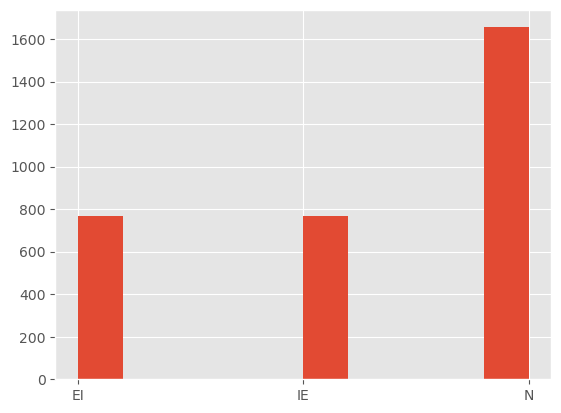

In [173]:
df['Class'].hist()

# Preparo do dataset

In [174]:
#remoção das instâncias com bases ambíguas

df = df[~idx_ndrs]

In [175]:
#converter colunas para categorical
for col in df.columns:
    df[col] = df[col].cat.remove_unused_categories()

# Encoding das features e targets

In [176]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

F = df.columns[:-1].to_list()
T = df.columns[-1]

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), F),
    ('oe', OrdinalEncoder(), [T]) #para este caso, LabelEncoder == OrdinalEncoder
])

In [177]:
encoded = ct.fit_transform(df).toarray()

# Divisão treino-teste
80% treino, 20% teste

In [178]:
from sklearn.model_selection import train_test_split

X = encoded[:, :-1]
y = encoded[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

In [179]:
# nessa parte, é necessário estratificar? As classes já parecem razoavelmente distribuídas

In [180]:
pd.Series(y_train).value_counts(normalize=True)

2.0    0.516929
1.0    0.243307
0.0    0.239764
dtype: float64

In [181]:
pd.Series(y_test).value_counts(normalize=True)

2.0    0.527559
0.0    0.240945
1.0    0.231496
dtype: float64

# Classificadores e parâmetros para busca
- kNN, DT, MLP, NB, SVM

In [182]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve

In [183]:
estimators = {'knn': KNeighborsClassifier(), 
              'dt': DecisionTreeClassifier(),
              'mlp': MLPClassifier(),
              'nb': BernoulliNB(),
              'svm': SVC(probability=True)}

In [184]:
#listagem de hiperparâmetros

for a, b in estimators.items():
    print("Parâmetros padrões para {}: \n{}\n".format(b, b.get_params()))

Parâmetros padrões para KNeighborsClassifier(): 
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

Parâmetros padrões para DecisionTreeClassifier(): 
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

Parâmetros padrões para MLPClassifier(): 
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation

In [185]:
#parâmetros para busca

param_grid = {
    
    'knn': [{
        'metric': ['minkowski'],
        'p': [1,2],
        'n_neighbors': [5, 7, 9, 11, 13, 15, 17, 19, 20, 30, 40, 50, 60, 70]
    },
    {
        'metric': ['hamming'],
        'n_neighbors': [5, 7, 9, 11, 13, 15, 17, 19, 20, 30, 40, 50, 60, 70]
    }],
    
    'dt': {
        'criterion': ["gini", "entropy"],
        'min_samples_leaf': [1, 2, 3]
    },
    
    'mlp': {
        'alpha': [0.01, 0.05, 0.1, 0.2]
    },
    
    'nb': {
        'alpha': [0.001, 0.01, 0.1, 1, 2, 10]
    },

    'svm': [{
        'C': [1, 2, 5, 10],
        'kernel': ['linear', 'rbf']
        },
        {
        'C': [1, 2, 5, 10],
        'kernel': ['poly'],
        'degree': [2, 3]
    }]

}


# 10-fold stratified cross-validation

In [186]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=rs)

# Baseline

In [187]:
from sklearn.dummy import DummyClassifier

dummy_clf_1 = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)
y_d1 = dummy_clf_1.predict(X_test)

dummy_clf_2 = DummyClassifier(strategy="stratified").fit(X_train, y_train)
y_d2 = dummy_clf_2.predict(X_test)

2023/07/26 23:10:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'eeb4bb33fac44e7fbaffe914d0943842', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
C:\Users\Caio\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023/07/26 23:10:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bdb8f4050b6641f4a264802f75db6107', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


In [188]:
print(f"Baseline de acurácia (prever o mais frequente) = {accuracy_score(y_d1, y_test)}")
print(f"Baseline de acurácia (prever aleatoriamente na mesma proporção) = {accuracy_score(y_d2, y_test)}")

Baseline de acurácia (prever o mais frequente) = 0.5275590551181102
Baseline de acurácia (prever aleatoriamente na mesma proporção) = 0.4


In [189]:
print(f"Baseline de f1_score (prever o mais frequente) = {f1_score(y_d1, y_test, average='macro')}")
print(f"Baseline de f1_score (prever aleatoriamente na mesma proporção) = {f1_score(y_d2, y_test, average='macro')}")

Baseline de f1_score (prever o mais frequente) = 0.23024054982817868
Baseline de f1_score (prever aleatoriamente na mesma proporção) = 0.34106575593203897


# Início tracking MLflow

In [190]:
import mlflow
import mlflow.sklearn

In [191]:
!start /b mlflow ui

In [192]:
mlflow.sklearn.autolog()

In [193]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [194]:
#função para gravar métricas de teste

def log_eval_metrics(actual, pred, pred_proba, prefix='test_'):
    
    f1 = f1_score(actual, pred, average='macro')
    acc = accuracy_score(actual, pred)
    roc_auc = roc_auc_score(actual, pred_proba, multi_class='ovr', average='macro') #'ovr' ou 'ovo'
    
    mlflow.log_metric(prefix + 'f1_score', f1)
    mlflow.log_metric(prefix + 'acc_score', acc)
    mlflow.log_metric(prefix + 'roc_auc_score', roc_auc)
    
    return f1, acc, roc_auc

# Grid Search CV

In [195]:
from sklearn.metrics import accuracy_score, make_scorer

metrics = {"AUC": make_scorer(roc_auc_score, multi_class='ovo', needs_proba=True),
           "Accuracy": make_scorer(accuracy_score),
           "F1-Score": make_scorer(f1_score, average='macro')}

In [196]:
from sklearn.model_selection import GridSearchCV

best_estimators = {}
cv_results_train = {}
results_test = {}

mlflow.end_run()

for est in estimators:
    
    est_name = str(estimators[est])
    est_est = estimators[est]
    est_params = param_grid[est]
    
    mlflow.start_run()
    mlflow.set_tag('estimator', est_name)
    
    print(f"Executando {est_name}...")
    
    grid = GridSearchCV(estimator = est_est,
                        param_grid = est_params,
                        scoring = metrics,
                        cv = cv,
                        verbose=2,
                        n_jobs=-1,
                        refit="F1-Score")
    
    grid.fit(X_train, y_train)
    
    cv_results_train[est] = grid.cv_results_
    best_estimators[est] = grid.best_estimator_
    
    #predição
    y_pred = grid.predict(X_test)
    y_pred_proba = grid.predict_proba(X_test)
    
    results_test[est] = log_eval_metrics(y_test, y_pred, y_pred_proba)

    mlflow.end_run()

Executando KNeighborsClassifier()...
Fitting 10 folds for each of 42 candidates, totalling 420 fits


2023/07/26 23:11:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Caio\AppData\Roaming\Python\Python39\site-packages\mlflow\sklearn\utils.py:788: UserWarning: Top 5 child runs will be created based on ordering in rank_test_AUC column.  You can choose not to limit the number of child runs created by setting `max_tuning_runs=None`."
2023/07/26 23:11:04 INFO mlflow.sklearn.utils: Logging the 5 best runs, 37 runs will be omitted.


Executando DecisionTreeClassifier()...
Fitting 10 folds for each of 6 candidates, totalling 60 fits


2023/07/26 23:11:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Caio\AppData\Roaming\Python\Python39\site-packages\mlflow\sklearn\utils.py:788: UserWarning: Top 5 child runs will be created based on ordering in rank_test_AUC column.  You can choose not to limit the number of child runs created by setting `max_tuning_runs=None`."
2023/07/26 23:11:11 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


Executando MLPClassifier()...
Fitting 10 folds for each of 4 candidates, totalling 40 fits


2023/07/26 23:11:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Caio\AppData\Roaming\Python\Python39\site-packages\mlflow\sklearn\utils.py:788: UserWarning: Top 5 child runs will be created based on ordering in rank_test_AUC column.  You can choose not to limit the number of child runs created by setting `max_tuning_runs=None`."
2023/07/26 23:11:42 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Executando BernoulliNB()...
Fitting 10 folds for each of 6 candidates, totalling 60 fits


2023/07/26 23:11:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Caio\AppData\Roaming\Python\Python39\site-packages\mlflow\sklearn\utils.py:788: UserWarning: Top 5 child runs will be created based on ordering in rank_test_AUC column.  You can choose not to limit the number of child runs created by setting `max_tuning_runs=None`."
2023/07/26 23:11:49 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


Executando SVC(probability=True)...
Fitting 10 folds for each of 16 candidates, totalling 160 fits


2023/07/26 23:13:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Caio\AppData\Roaming\Python\Python39\site-packages\mlflow\sklearn\utils.py:788: UserWarning: Top 5 child runs will be created based on ordering in rank_test_AUC column.  You can choose not to limit the number of child runs created by setting `max_tuning_runs=None`."
2023/07/26 23:13:04 INFO mlflow.sklearn.utils: Logging the 5 best runs, 11 runs will be omitted.


In [197]:
#funções auxiliares para gerar dataframes com métricas para análises

import re

def generate_train_metrics(table):
    rt = table.copy()
    for key in rt:
        rt[key] = pd.DataFrame(rt[key])
        discard_cols = [x for x in rt[key].columns if re.compile(r"param_.*").match(x)]
        rt[key]['estimator_name'] = key
        rt[key] = rt[key].drop(columns=discard_cols)
    
    return pd.concat(rt.values())

def generate_test_metrics(table):
    ans = pd.DataFrame(table).T
    ans.columns = ['f1', 'acc', 'roc_auc']
    return ans

In [198]:
train_metrics_df = generate_train_metrics(cv_results_train)
test_metrics_df = generate_test_metrics(results_test)

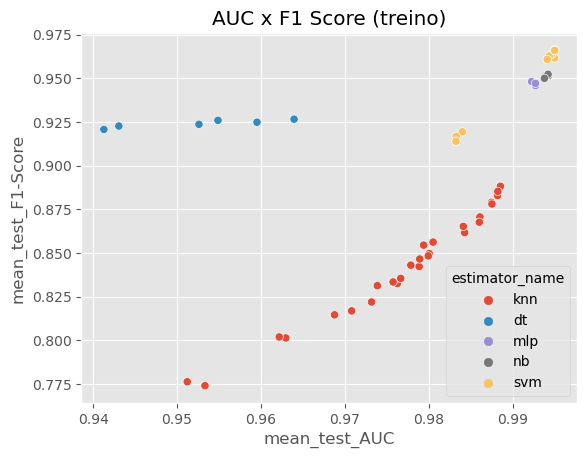

In [199]:
#potencialmente existe algum erro de cálculo nos scors do SVM
sns.scatterplot(x='mean_test_AUC', y='mean_test_F1-Score', data=results_df, hue='estimator_name')
plt.title("AUC x F1 Score (treino)")
plt.show()

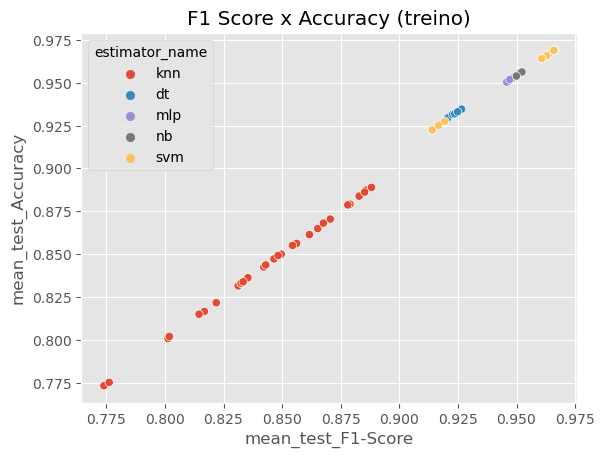

In [200]:
sns.scatterplot(x='mean_test_F1-Score', y='mean_test_Accuracy', data=results_df, hue='estimator_name')
plt.title("F1 Score x Accuracy (treino)")
plt.show()

Text(0.5, 1.0, 'Métricas (validação)')

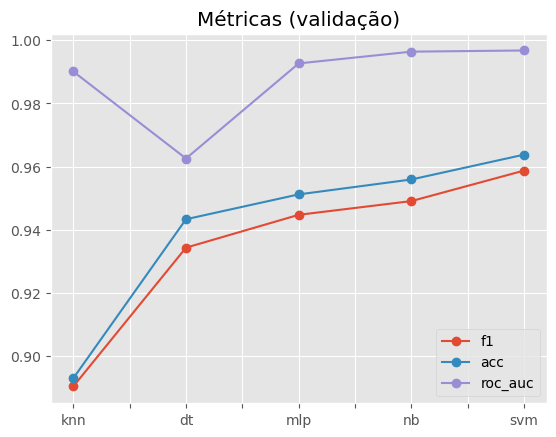

In [201]:
test_metrics_df.plot(marker='o')
plt.title("Métricas (validação)")

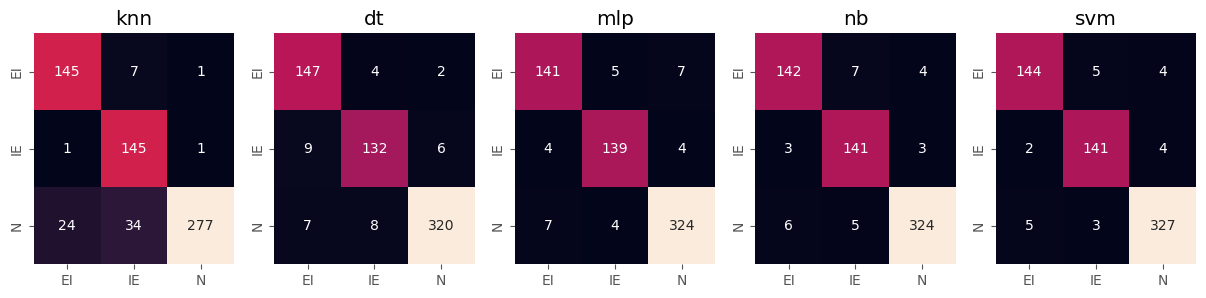

In [253]:
from sklearn.metrics import confusion_matrix

conf_mats = [confusion_matrix(y_test, b.predict(X_test)) for b in best_estimators.values()]
labels = list(estimators.keys())
classes = ct.transformers_[1][1].categories_[0].tolist()

fig, ax = plt.subplots(1,5, figsize=(15,3))

for i, cm in enumerate(conf_mats):
    sns.heatmap(cm, annot=True, fmt="", cbar=False, ax=ax[i])
    ax[i].set_xticklabels(classes)
    ax[i].set_yticklabels(classes)
    ax[i].set_title(labels[i])